In [137]:
import numpy as np
import pandas as pd
import seaborn_image as isns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
from skimage.transform import resize




References:
https://neuraldatascience.io/8-mri/read_viz.html

In [153]:
input_path = 'Alzheimer_s Dataset/train'
categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] #our labels manually set
#or os.listdir(input_path)

images = []
labels = []

numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    numberofimages.append(len(os.listdir(os.path.join(input_path,category))))
    for file in os.listdir(os.path.join(input_path, category)):
        image_paths = os.path.join(input_path,category, file) #image in this case refers to title of the image
        image = imread(image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images.append(image)
        labels.append(category)


In [4]:
#number of images
numberofimages

[2560, 1792, 717, 52]

In [108]:
#Splitting it to respective list
nonDemented = images[1:2561]
veryMildDemented = images[2561:4353]
MildDemented = images[4353:5070]
ModerateDemented = images[5069:5122]

lst = [nonDemented, veryMildDemented, MildDemented, ModerateDemented]

In [154]:
#dimensions of an image
print(nonDemented[1].shape)

(208, 176)


In [ ]:
plt.imshow(nonDemented[])

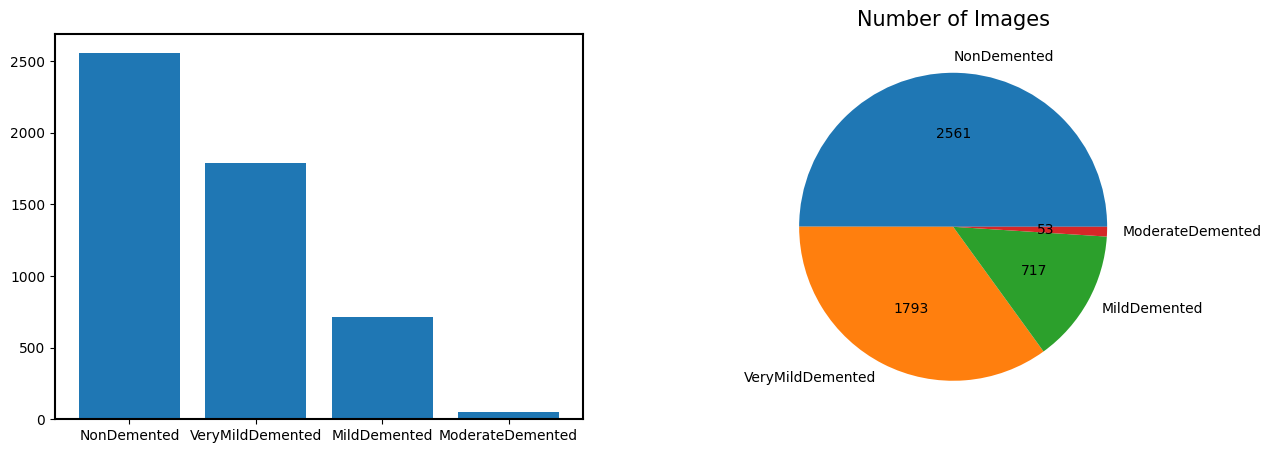

In [94]:
#Plotting number of images for visual representation
fig, ax = plt.subplots(1,2 , figsize = (15,5))
ax[0].bar(categories, numberofimages)
ax[1].pie(numberofimages, labels= categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages)))
ax[1].set_title('Number of Images')
plt.show()

#Shows some need for data augmentation since insufficient samples for ModerateDemented.
#We can do rotations or cropping into image for data augmentation.

#Things to analyze
Shape of dataset1 and dataset2 --- pixels
Most important section of data(like can we somehow extract)
identity the progression of alzheimer maybe how much the white part increases in its mean for each stage

No. of Obs. : 36608
Min. Value : 0
Max. Value : 255
Mean : 77.70159527972028
Variance : 7678.814331325585
Skewness : 0.5393340062122196


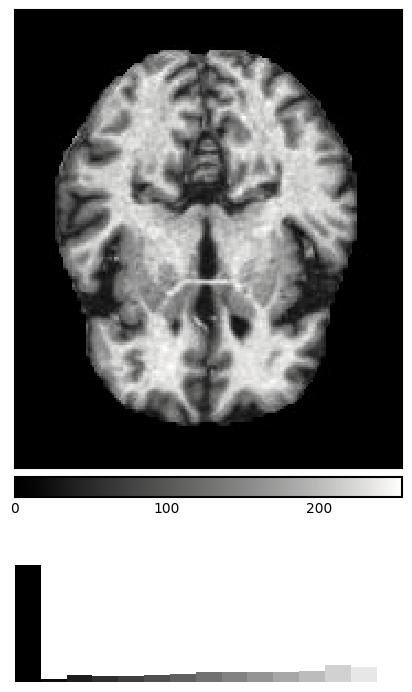

In [77]:
z = isns.imghist(veryMildDemented[1], cmap = 'gray', describe= True, bins = 15, orientation= 'h', alpha= 1)

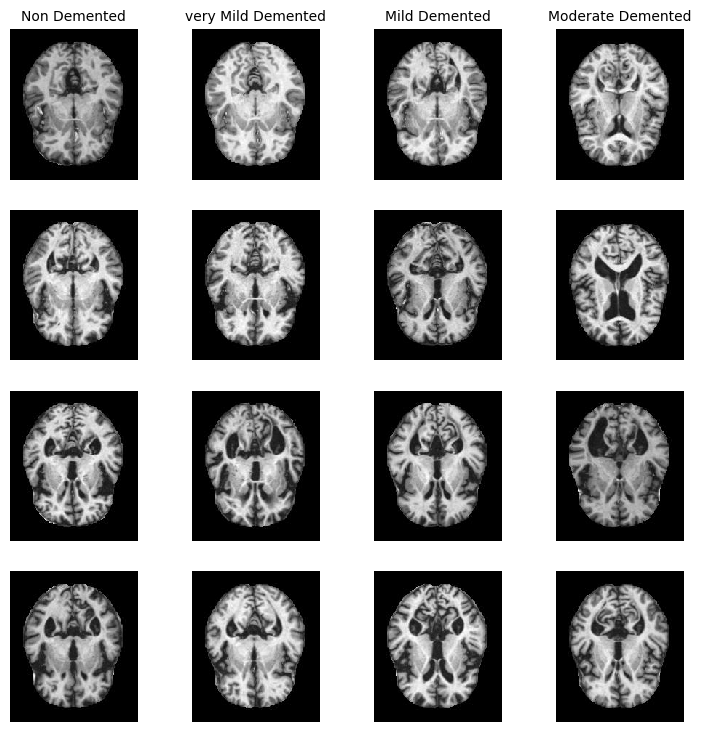

In [132]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like
fig,axes = plt.subplots(4,4, figsize = (9,9))

for i in range(len(lst)):
    for j in range(4):
        img = lst[i][j]
        axes[i,j].imshow(img, cmap = 'gray')
        axes[i,j].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 10)
axes[0,1].set_title('very Mild Demented', fontsize = 10)
axes[0,2].set_title('Mild Demented', fontsize = 10)
axes[0,3].set_title('Moderate Demented', fontsize = 10)
plt.show()

In [155]:
np.max(nonDemented[1])

252

In [ ]:
#Flatten 5 images and join them together then plot a histogram to get the rough distribution of the pixels rgb;


(array([17820.,   112.,   431.,   495.,   574.,   636.,   728.,   828.,
         1005.,  1353.,  1603.,  1469.,  1613.,  1515.,  1443.,  1191.,
         1360.,  1426.,   821.,   185.]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

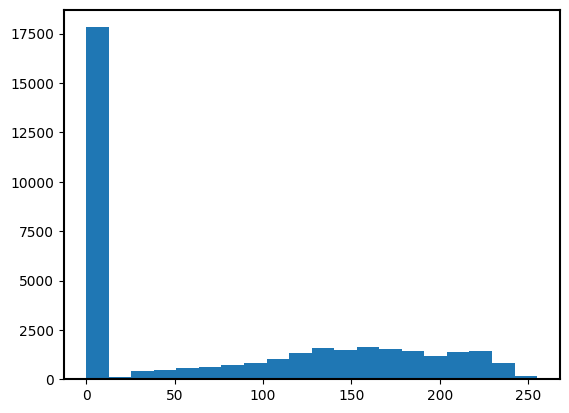

In [168]:
plt.hist(nonDemented[3].flatten(), bins = 20)

(array([17848.,   133.,   651.,   814.,   834.,   775.,   830.,   787.,
          914.,   954.,  1081.,  1201.,  1267.,  1209.,  1133.,  1285.,
         1781.,  1935.,  1061.,   115.]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

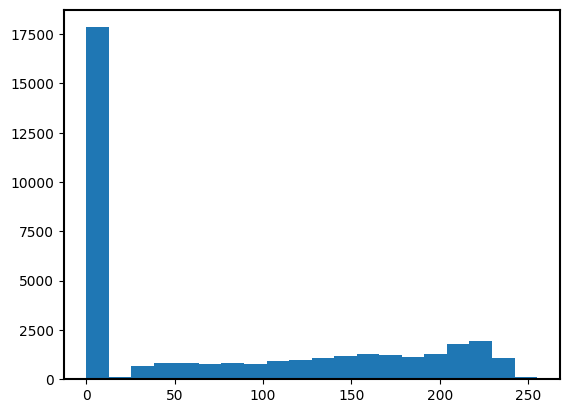

In [166]:

plt.hist(ModerateDemented[1].flatten(), bins = 20)

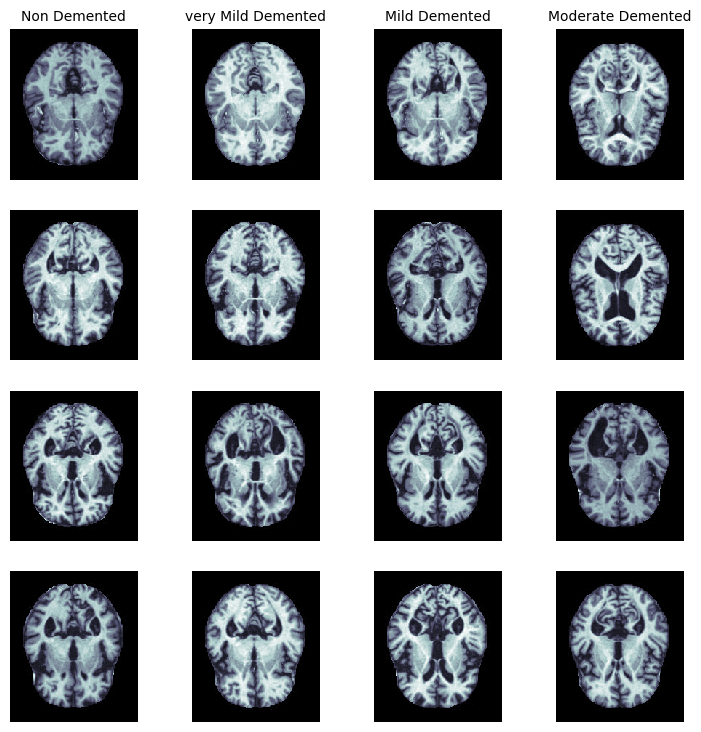

In [136]:
#With different color scheme which better shows difference
fig,axes = plt.subplots(4,4, figsize = (9,9))

for i in range(len(lst)):
    for j in range(4):
        img = lst[i][j]
        axes[i,j].imshow(img, cmap = 'bone')
        axes[i,j].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 10)
axes[0,1].set_title('very Mild Demented', fontsize = 10)
axes[0,2].set_title('Mild Demented', fontsize = 10)
axes[0,3].set_title('Moderate Demented', fontsize = 10)
plt.show()

<AxesSubplot:>

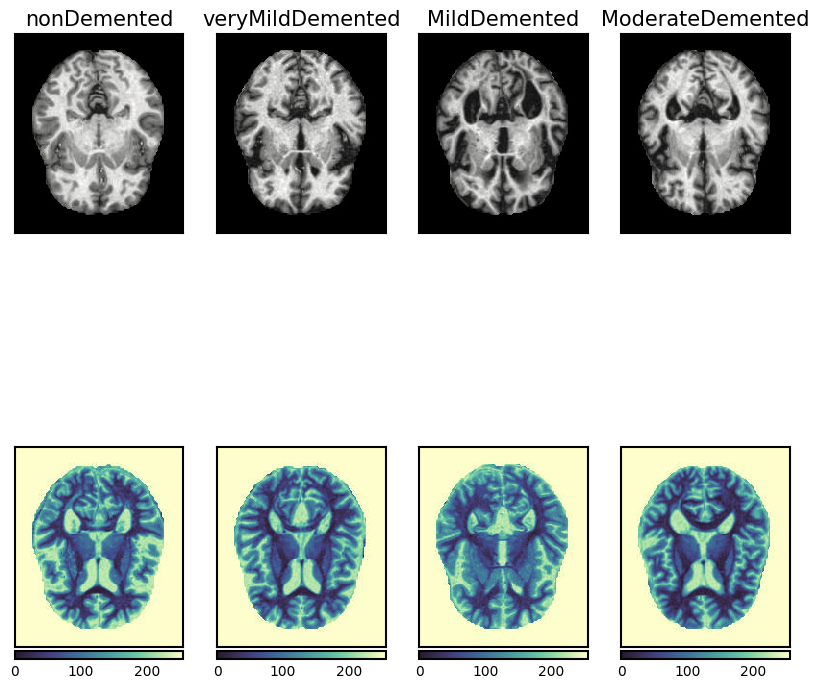

In [55]:
fig, axes = plt.subplots(2,4, figsize = (10,10))
isns.imgplot(nonDemented[1], gray= True, ax= axes[0,0], orientation= 'h', cbar=False)
axes[0,0].set_title('nonDemented')
isns.imgplot(veryMildDemented[1], gray= True, ax = axes[0,1],orientation= 'h', cbar = False)
axes[0,1].set_title('veryMildDemented')
isns.imgplot(MildDemented[1], gray = True, ax = axes[0,2],orientation= 'h', cbar = False)
axes[0,2].set_title('MildDemented')
isns.imgplot(ModerateDemented[1], gray = True, ax = axes[0,3],orientation= 'h', cbar = False)
axes[0,3].set_title('ModerateDemented')

#make it into rgb so can visualize better
isns.imgplot(np.invert(nonDemented[20]), gray= True, ax= axes[1,0], orientation= 'h', cmap = 'deep')
isns.imgplot(np.invert(veryMildDemented[20]), gray= True, ax = axes[1,1],orientation= 'h', cmap='deep')
isns.imgplot(np.invert(MildDemented[20]), gray = True, ax = axes[1,2],orientation= 'h', cmap = 'deep')
isns.imgplot(np.invert(ModerateDemented[20]), gray = True, ax = axes[1,3],orientation= 'h', cmap = 'deep')



using the first images as an example, its abit harder to differentiate between milddemented and moderate demented

In [9]:
np.average(np.average(ModerateDemented, axis=0), axis = 1).shape

(208,)

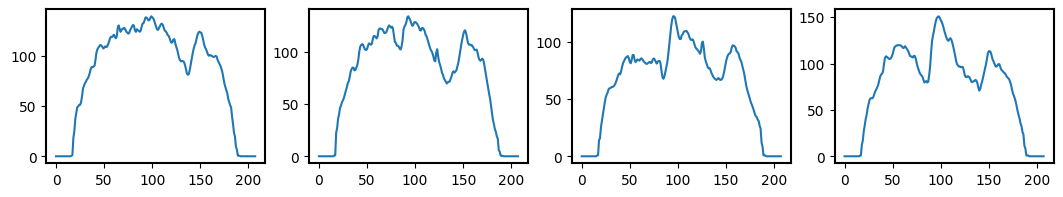

In [10]:
fig, axes = plt.subplots(1,4, figsize = (13,2))
axes[0].plot(nonDemented[1].mean(axis = 1))
axes[1].plot(veryMildDemented[1].mean(axis = 1))
axes[2].plot(MildDemented[1].mean(axis=1))
axes[3].plot(ModerateDemented[1].mean(axis=1))

average plot of our grayscale in each column for each picture above


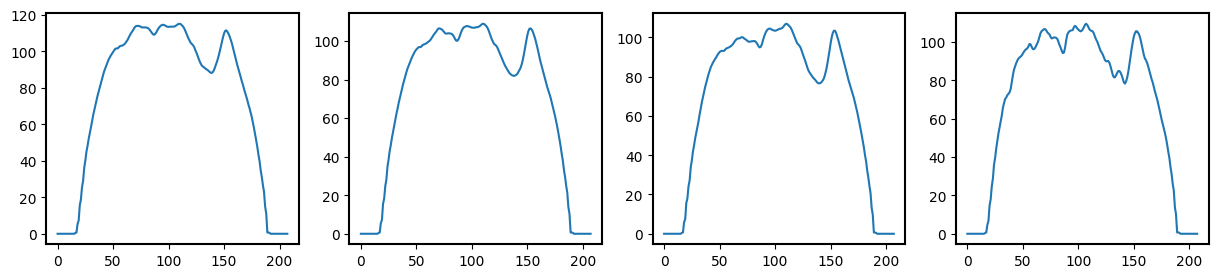

In [11]:
fig, axes = plt.subplots(1,4, figsize = (15,3))
axes[0].plot(np.average(np.average(nonDemented, axis=0), axis = 1))
axes[1].plot(np.average(np.average(veryMildDemented, axis=0), axis = 1))
axes[2].plot(np.average(np.average(MildDemented, axis=0), axis = 1))
axes[3].plot(np.average(np.average(ModerateDemented, axis=0), axis = 1))

plt.show()

meaningful x axis features = 50 to 170?
check the meaningful y matrix attributes -- pixels 40-130?

to do: overlay my subplots

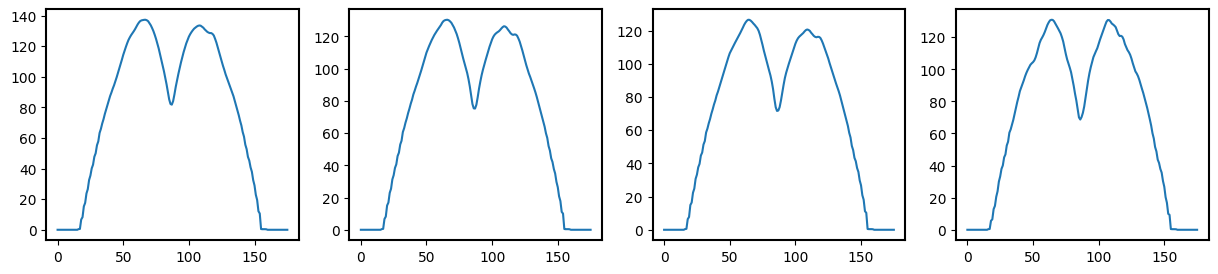

In [12]:
fig, axes = plt.subplots(1,4, figsize = (15,3))
axes[0].plot(np.average(np.average(nonDemented, axis=1), axis = 0))
axes[1].plot(np.average(np.average(veryMildDemented, axis=1), axis = 0))
axes[2].plot(np.average(np.average(MildDemented, axis=1), axis = 0))
axes[3].plot(np.average(np.average(ModerateDemented, axis=1), axis = 0))

calculating the total average grayscale -- aka average matrix is not insightful -- but we can identify the rough points where it might be insightful if we did an extraction

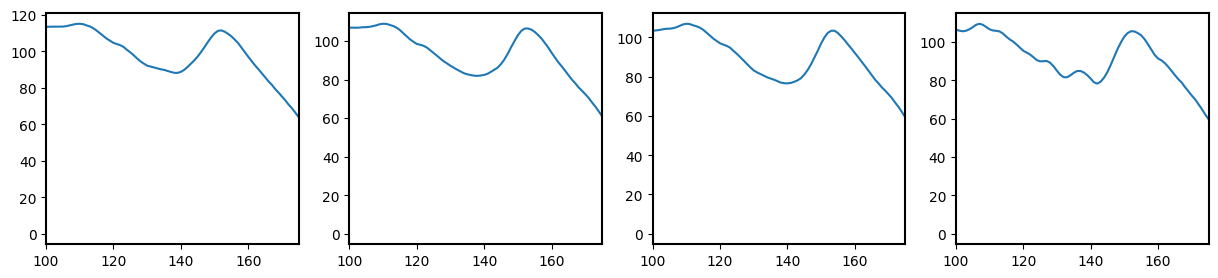

In [13]:
fig, axes = plt.subplots(1,4, figsize = (15,3))
axes[0].plot(np.average(np.average(nonDemented, axis=0), axis = 1))
axes[1].plot(np.average(np.average(veryMildDemented, axis=0), axis = 1))
axes[2].plot(np.average(np.average(MildDemented, axis=0), axis = 1))
axes[3].plot(np.average(np.average(ModerateDemented, axis=0), axis = 1))

plt.setp(axes, xlim = (100,175))
plt.show()

In [14]:
min(np.average(np.average(nonDemented, axis=0), axis = 1))

0.0

In [55]:
from skimage.color import rgb2hsv
from skimage.segmentation import chan_vese
import skimage as ski
from skimage import exposure

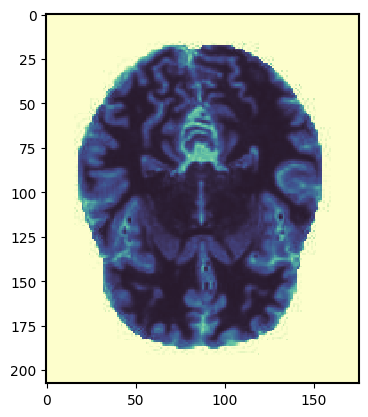

In [80]:
im1 = exposure.adjust_gamma(np.invert(nonDemented[1]),2)
plt.imshow(im1,)



In [101]:
im1 = exposure.adjust_gamma(np.invert(ModerateDemented[1]), 2)
im2 = exposure.adjust_gamma(np.invert(MildDemented[20]),-2)
#plt.imshow(im1, cmap = 'jet')
plt.imshow(im2, cmap = 'jet')

ValueError: Gamma should be a non-negative real number.

<AxesSubplot:>

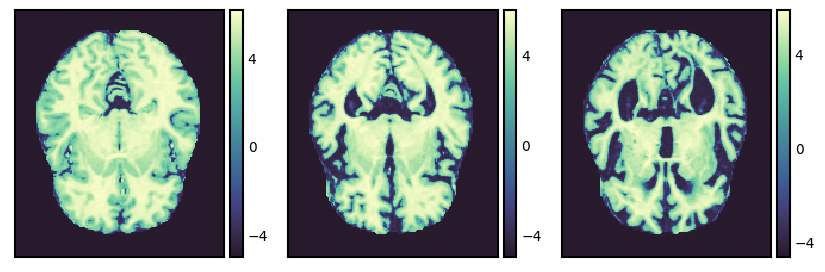

In [50]:

im1 = nonDemented[1]
im2 = ModerateDemented[1]
im3 = MildDemented[1]
cv = chan_vese(im1, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
cv2 = chan_vese(im2, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
cv3 = chan_vese(im3, mu=0.001, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)
fig, axes = plt.subplots(1,3, figsize = (10,10))
isns.imshow(cv[1], ax = axes[0])
isns.imshow(cv2[1], ax = axes[1])
isns.imshow(cv3[1], ax = axes[2])